## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation, Dropout, regularizers
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128, 64], use_bn=True, drp_ratio=0., l2_ratio=0.):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)

            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 3
BATCH_SIZE = 128

USE_BN = [True, False]
DRP_RATIO = [0., 0.4, 0.8]
L2_RATIO = [0., 1e-6, 1e-8]

In [7]:
import keras.backend as K
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    K.clear_session()
    print("Numbers of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f" % (i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, with bn: True, drp_ratio: 0.00, l2_ratio: 0.00
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
____

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 18s 356us/step - loss: 1.6442 - acc: 0.4169 - val_loss: 1.8430 - val_acc: 0.3409
Epoch 2/3
50000/50000 [==============================] - 14s 271us/step - loss: 1.4167 - acc: 0.4943 - val_loss: 1.9439 - val_acc: 0.3442
Epoch 3/3
50000/50000 [==============================] - 14s 270us/step - loss: 1.3102 - acc: 0.5337 - val_loss: 1.8030 - val_acc: 0.3900
Numbers of exp: 3, with bn: True, drp_ratio: 0.40, l2_ratio: 0.00
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 25s 494us/step - loss: 2.0273 - acc: 0.2742 - val_loss: 1.7486 - val_acc: 0.3737
Epoch 2/3
50000/50000 [==============================] - 20s 407us/step - loss: 1.7737 - acc: 0.3604 - val_loss: 1.7115 - val_acc: 0.3991
Epoch 3/3
50000/50000 [==============================] - 20s 402us/step - loss: 1.6895 - acc: 0.3980 - val_loss: 1.6829 - val_acc: 0.4083
Numbers of exp: 6, with bn: True, drp_ratio: 0.80, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
________

50000/50000 [==============================] - 33s 667us/step - loss: 2.7093 - acc: 0.1181 - val_loss: 2.2198 - val_acc: 0.21902.7306 - acc: 0.1 - ETA: 1s - loss: 2
Epoch 2/3
50000/50000 [==============================] - 34s 685us/step - loss: 2.2414 - acc: 0.1577 - val_loss: 2.0959 - val_acc: 0.2382
Epoch 3/3
50000/50000 [==============================] - 34s 687us/step - loss: 2.1341 - acc: 0.1877 - val_loss: 2.0089 - val_acc: 0.2596
Numbers of exp: 9, with bn: False, drp_ratio: 0.00, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
______________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 79s 2ms/step - loss: 2.1997 - acc: 0.1605 - val_loss: 2.0264 - val_acc: 0.2481 - 
Epoch 2/3
50000/50000 [==============================] - 45s 895us/step - loss: 2.1131 - acc: 0.1876 - val_loss: 2.0094 - val_acc: 0.2729
Epoch 3/3
50000/50000 [==============================] - 41s 818us/step - loss: 2.0896 - acc: 0.1921 - val_loss: 1.9920 - val_acc: 0.2725
Numbers of exp: 13, with bn: False, drp_ratio: 0.40, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_____

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 49s 986us/step - loss: 2.3755 - acc: 0.0994 - val_loss: 2.3033 - val_acc: 0.1000
Epoch 2/3
50000/50000 [==============================] - 48s 966us/step - loss: 2.3034 - acc: 0.0972 - val_loss: 2.3033 - val_acc: 0.1000
Epoch 3/3
50000/50000 [==============================] - 46s 925us/step - loss: 2.3034 - acc: 0.0980 - val_loss: 2.3033 - val_acc: 0.1000
Numbers of exp: 17, with bn: False, drp_ratio: 0.80, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
______

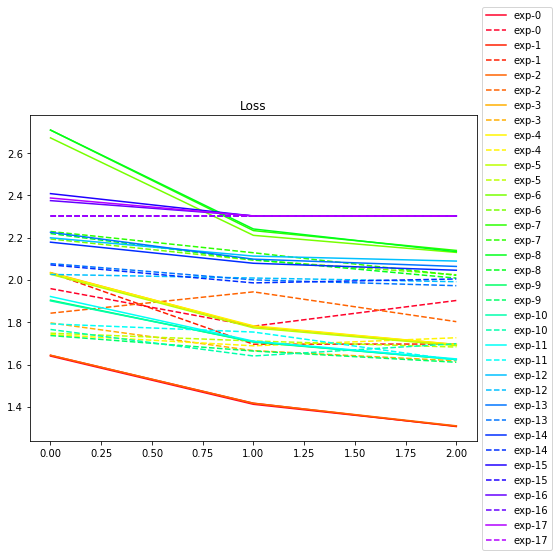

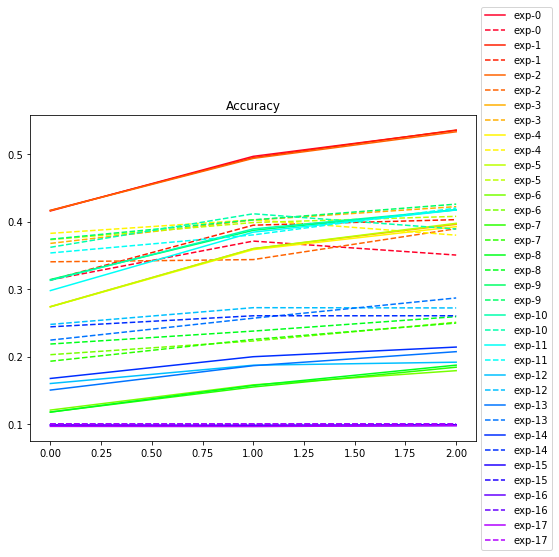

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
"""Code Here
將結果繪出
"""

NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()